In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

# (f) Parameters and calibration

In [2]:
# Exogenous parameters
parameters = {}
parameters['K0'] = 20
parameters['β'] = 0.984
parameters['δ'] = 0.025
parameters['α'] = 0.33
parameters['θ'] = 1
parameters['γ'] = 2

# AR(1) parameters
parameters['ρ'] = 0.9
parameters['σ'] = 0.005

# Discretization counts
parameters['znodes'] = 21
parameters['knodes'] = 501

# To find ψ, solve for the steady state labour = 1/3 (consumer spends a third of their day working)

def calculate_psi(parameters):
    alpha = parameters['α']
    beta = parameters['β']
    delta = parameters['δ']
    theta = parameters['θ']
    
    inner_term = (alpha * beta) / (1 - beta * (1 - delta))
    numerator = (1 - alpha) * (inner_term ** (alpha / (1 - alpha)))
    
    denominator = (1/3) ** theta
    psi = numerator / denominator
    
    return psi

parameters['ψ'] = calculate_psi(parameters)

# (g) Value function iteration 

In [3]:
def calculate_steady_state(params):
    
    alpha = params.get('α')
    beta = params.get('β')
    delta = params.get('δ')
    theta = params.get('θ')
    psi = params.get('ψ')

    # R (return to capital)
    R = (1 - beta*(1 - delta)) / beta

    # r (interest rate)
    r = (1 - beta) / beta

    # K/N (capital-labor ratio)
    K_N = (alpha * beta / (1 - beta*(1 -delta))) ** (1 / (1 - alpha))

    # w (real wage)
    w = (1 - alpha) * (alpha * beta / (1 - beta*(1 - delta))) ** (alpha / (1 - alpha))

    # N (labor input)
    N = (w / psi) ** (1 / theta)

    # K (capital stock)
    K = N * K_N

    # Y (output)
    Y = N * (K_N ** alpha)

    # C (consumption)
    C = Y - delta * K
    
    # I (Investment)
    I = Y - C

    return 1, K, N, Y, C, I, w, r, R

Zss, Kss, Nss, Yss, Css, Iss, wss, rss, Rss = calculate_steady_state(parameters)

In [4]:
# Rouwenhorst method to discretize the technology space

def rouwenhorst(rho, sigma, n, mu = 0):
    '''
    We assume that the shock follows a standard Normal distribution.
    The parameters that go inside the function are are:
        mu: average of the AR(1) process
        rho: autocorrelation of the AR(1) process
        n: number of states of the shock
        sigma: standard deviation of the shock
    '''
    n = int(n)
    sigma_y = np.sqrt(sigma**2/(1 - rho**2))
    p = (1 + rho)/2
    q = p
    psi = sigma_y*np.sqrt((n - 1)/(1-rho**2))
    P = np.array([[p, 1 - p],
                 [1 - q, q]])

    if n > 2:
        for i in range(1, n - 1):
            θ1 = np.vstack((np.hstack((P, np.zeros((i+1,1)))), np.zeros((1, i+2))))
            θ2 = np.vstack((np.hstack((np.zeros((i+1,1)), P)), np.zeros((1, i+2))))
            θ3 = np.vstack((np.zeros((1, i+2)), np.hstack((P, np.zeros((i+1,1))))))
            θ4 = np.vstack((np.zeros((1, i+2)), np.hstack((np.zeros((i+1,1)), P))))
            P = p*θ1 + (1-p)*θ2 + (1-q)*θ3 + q*θ4
            P[1:i+1, :] = P[1:i+1, :]/2
    
    z_grid = np.linspace(mu/(1-rho) - psi, mu/(1-rho) + psi, n)
    
    return z_grid, P

z, P = rouwenhorst(parameters['ρ'], parameters['σ'], parameters['znodes'])
prod = np.exp(z).reshape(-1,1)

# Discretizing capital grid around the steady state
spread = 0.1 
kgrid = np.linspace(Kss - spread * Kss, Kss + spread * Kss, parameters['knodes'])

In [5]:
parameters['zgrid'] = prod.reshape(-1,1)
parameters['kgrid'] = kgrid.reshape(-1,1)
parameters['P'] = P

In [6]:
# Function to find the optimal amount of consumption each period
def consumption(k, params):
    alpha = params['α']
    delta = params['δ']
    z_grid = params['zgrid']
    k_grid = params['kgrid']
    c = z_grid*k**alpha*labor(z, k, params)**(1-alpha) + (1-delta)*k - k_grid.T
    
    return c

In [7]:
# Function to find the optimal amount of labor supplied
def labor(z, k, params, scalar = 0):
    alpha = params['α']
    psi = params['ψ']
    theta = params['θ']
    
    if scalar == 0:
        z_grid = params['zgrid']
    elif scalar == 1:
        z_grid = z
    
    n = ((1/psi)*(1-alpha)*z_grid*k**alpha)**(1/(theta + alpha))
    
    return n

In [8]:
def consumer_problem(V_guess, params):
    beta = params['β']
    psi = params['ψ']
    alpha = params['α']
    theta = params['θ']
    delta = params['δ']
    gamma = params['γ']
    P = params['P']
    z_nodes = params['znodes']
    k_nodes = params['knodes']
    k_grid = params['kgrid']
    z_grid = params['zgrid']
    
    V = np.zeros((z_nodes, k_nodes))
    policy = V.copy()
    opt = V.copy()
    
    for i in range(k_nodes):
        k = k_grid[i]
        N = labor(z, k, params)
        C = consumption(k, params)
        utility = C - psi*N**(1+theta)/(1+theta)
        np.place(utility, utility < 0, 0)
        V[:,i] = np.max(utility**(1-gamma)/(1-gamma) + beta*P@V_guess, axis = 1)
        policy[:,i] = np.argmax((1/(1-gamma))*utility**(1-gamma) + beta*P@V_guess, axis = 1)
        policy = np.asarray(policy, dtype = 'int')
        
    return V, policy

In [9]:
# Value function iteration

maxit = 1000
tol = 1e-8
V_guess = np.zeros((parameters['znodes'], parameters['knodes']))
for i in range(maxit):
    V_new, Pol = consumer_problem(V_guess, parameters)
    dif = abs(np.sum(V_new - V_guess))
    if (i + 1) % 250 == 0:
        print('Iteration:', i + 1)
        print('Difference:', dif)
    if dif < tol:
        print('Converged.')
        break
    V_guess = V_new

Iteration: 250
Difference: 450.6064527390237
Iteration: 500
Difference: 7.990457399982546
Iteration: 750
Difference: 0.14169229897566993
Iteration: 1000
Difference: 0.002512585528137379


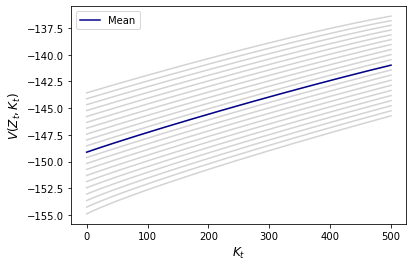

In [10]:
# Plotting the values associated with each state of the productivity vector

V, pol = consumer_problem(V_guess, parameters)
plt.plot(V.T, color = 'lightgrey')
plt.plot(np.mean(V.T, axis = 1), color = 'darkblue', label = 'Mean')
plt.xlabel('$K_t$', fontsize = 12)
plt.ylabel('$V(Z_t, K_t)$', fontsize = 12)
plt.legend()
plt.show()

# (h) Stationary and Ergodic distributions

In [12]:
pol = np.asarray(pol, dtype = 'int')

# Extracting the capital chosen by the policy function
output = {}
output['KPol'] = parameters['kgrid'][pol]
output['KChoice'] = pol
output['kgrid'] = parameters['kgrid']
output['Kss'] = Kss
output['P'] = P
output['zgrid'] = z

In [13]:
# Defineing a function to simulate a Markov Chain
def markov_chain(params, x0 = 0):
    
    # Extracting the transition probability matrix and the horizon for the simulation
    P = params['P']
    T = params['T']
    
    # Computing the CDF of each row
    P_CDF = np.array([np.cumsum(P[i, :]) for i in range(len(P))])
    
    # Generating our T number of states according to a uniform distribution between 0 and 1
    draw = np.random.uniform(0, 1, T)
    
    # Simulating the path
    x = np.zeros(T + 1)
    x[0] = x0 # Initial state
    i = x0
    state = []
    for t in range(T):
        for j in range(len(P.T)):
            if draw[t] < P_CDF[i, j]:
                i = j
                break
        state.append(i)
        
    # Including our first state
    states = [x0] + state
                
    return states

In [14]:
T = 100
parameters['T'] = T

# Number of simulations (each one of them with T periods)
n = 20000
simulations = []

for i in range(n):
    simulations.append(markov_chain(parameters, x0 = 20))
    if (i+1) % 5000 == 0:
        print(f'{i+1} iterations done')

Z = np.zeros((parameters['T'] + 1, n))
for i in range(n):
    Z[:,i] = simulations[i]

Z = np.asarray(Z, dtype = 'int')

5000 iterations done
10000 iterations done
15000 iterations done
20000 iterations done


In [15]:
# Pre allocating for efficiency
kpath = np.asarray(np.zeros((parameters['T'] + 1, n)) + (parameters['knodes'] + 1)/2, dtype = 'int')
zpath = np.zeros((parameters['T'], n))
npath = zpath.copy()
ypath = zpath.copy()
cpath = zpath.copy()
ipath = zpath.copy()

In [16]:
# Extracting the values
for i in range(n):
    for j in range(1, parameters['T'] + 1):
        kpath[j,i] = output['KChoice'][Z[j-1,i], kpath[j-1, i]]
        k_now = output['kgrid'][kpath[j-1,i]]
        k_tomorrow = output['kgrid'][kpath[j,i]]
        zpath[j-1, i] = output['zgrid'][Z[j-1, i]]
        z = zpath[j-1, i]
        npath[j-1, i] = labor(np.exp(z), k_now, parameters, scalar = 1)
        ypath[j-1, i] = np.exp(z)*k_now**parameters['α']*npath[j-1, i]**(1-parameters['α'])
        cpath[j-1, i] = ypath[j-1, i] + (1-parameters['δ'])*k_now - k_tomorrow
        ipath[j-1, i] = ypath[j-1, i] - cpath[j-1, i]
    if (i+1) % 5000 == 0:
        print(f'{i+1} simulation values extracted')

5000 simulation values extracted
10000 simulation values extracted
15000 simulation values extracted
20000 simulation values extracted


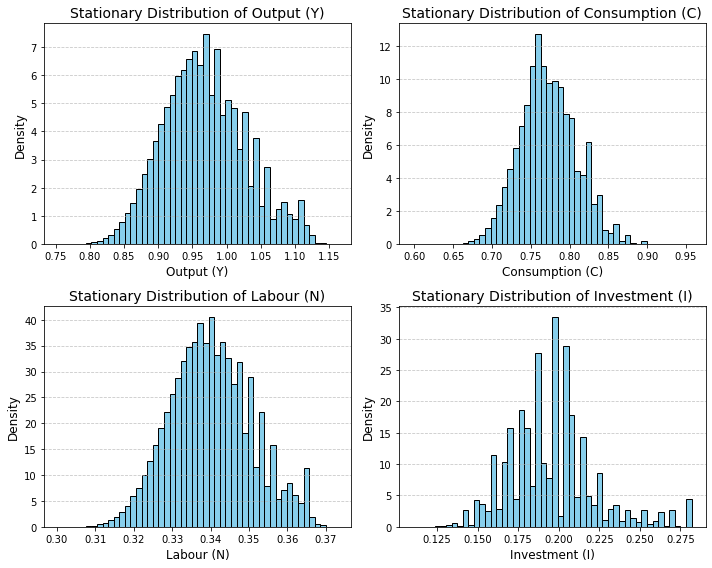

In [17]:
y_values = ypath.flatten()
c_values = cpath.flatten()
n_values = npath.flatten()
i_values = ipath.flatten()

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
variables = [
    (y_values, 'Output (Y)'),
    (c_values, 'Consumption (C)'),
    (n_values, 'Labour (N)'),
    (i_values, 'Investment (I)')
]

for ax, (values, variable_name) in zip(axs.flatten(), variables):
    ax.hist(values, bins = 50, density = True, color = 'skyblue', edgecolor = 'black')
    ax.set_xlabel(variable_name, fontsize = 12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'Stationary Distribution of {variable_name}', fontsize=14)
    ax.grid(axis='y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

In [18]:
# Now we do only one simulation but with a large number of T to obtain the Ergodic distribution
n_erg = 1
parameters['T'] = 500000

# Number of simulations
Z_erg = np.array(markov_chain(parameters, x0 = 11)).reshape(-1,1)

In [19]:
# Pre allocating for efficiency
kpath_erg = np.asarray(np.zeros((parameters['T'] + 1, n_erg)) + (parameters['knodes'] + 1)/2, dtype = 'int')
zpath_erg = np.zeros((parameters['T'], n_erg))
npath_erg = zpath_erg.copy()
ypath_erg = zpath_erg.copy()
cpath_erg = zpath_erg.copy()
ipath_erg = zpath_erg.copy()

In [20]:
for i in range(n_erg):
    for j in range(1, parameters['T'] + 1):
        kpath_erg[j,i] = output['KChoice'][Z_erg[j-1], kpath_erg[j-1, i]]
        k = output['kgrid'][kpath_erg[j-1,i]]
        kk = output['kgrid'][kpath_erg[j,i]]
        zpath_erg[j-1, i] = output['zgrid'][Z_erg[j-1, i]]
        z = zpath_erg[j-1, i]
        npath_erg[j-1, i] = labor(np.exp(z), k, parameters, scalar = 1)
        ypath_erg[j-1, i] = np.exp(z)*k**parameters['α']*npath_erg[j-1, i]**(1-parameters['α'])
        cpath_erg[j-1, i] = ypath_erg[j-1, i] + (1-parameters['δ'])*k - kk
        ipath_erg[j-1, i] = ypath_erg[j-1, i] - cpath_erg[j-1, i]

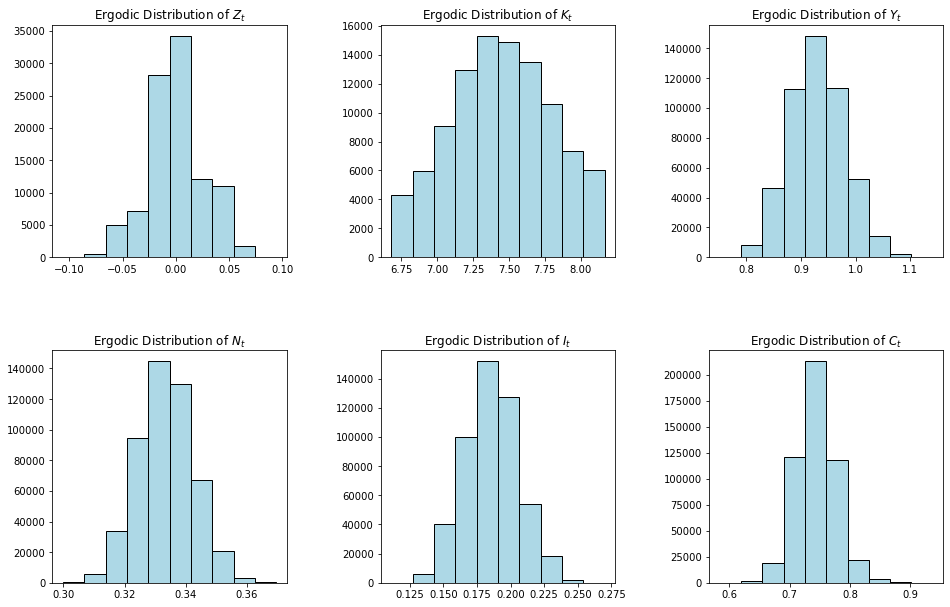

In [24]:
# Defining a burn rate so the initial condition does not matter
burn = 0.2

fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # Adjust figure size for better spacing
fig.subplots_adjust(right=0.95, top=0.9, hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

ax[0,0].hist(zpath_erg[:int(burn * parameters['T'])], ec='black', color='lightblue')
ax[0,0].title.set_text('Ergodic Distribution of $Z_t$')

ax[0,1].hist(output['kgrid'][kpath_erg].flatten()[:int(burn * parameters['T'])], ec='black', color='lightblue')
ax[0,1].title.set_text('Ergodic Distribution of $K_t$')

ax[0,2].hist(ypath_erg, ec='black', color='lightblue')
ax[0,2].title.set_text('Ergodic Distribution of $Y_t$')

ax[1,0].hist(npath_erg, ec='black', color='lightblue')
ax[1,0].title.set_text('Ergodic Distribution of $N_t$')

ax[1,1].hist(ipath_erg, ec='black', color='lightblue')
ax[1,1].title.set_text('Ergodic Distribution of $I_t$')

ax[1,2].hist(cpath_erg, ec='black', color='lightblue')
ax[1,2].title.set_text('Ergodic Distribution of $C_t$')

plt.show()

# (i) Covariance matric for Y, C, N, I

In [22]:
# Using Ergodic distribution to compute the covariances
df = pd.DataFrame({
    'Y': ypath_erg.flatten(),
    'N': npath_erg.flatten(),
    'C': cpath_erg.flatten(),
    'I': ipath_erg.flatten()
})

correlation_matrix = df.corr()
print(correlation_matrix)

          Y         N         C         I
Y  1.000000  0.999836  0.970808  0.919190
N  0.999836  1.000000  0.970530  0.919235
C  0.970808  0.970530  1.000000  0.797898
I  0.919190  0.919235  0.797898  1.000000


# (j) Impulse response functions

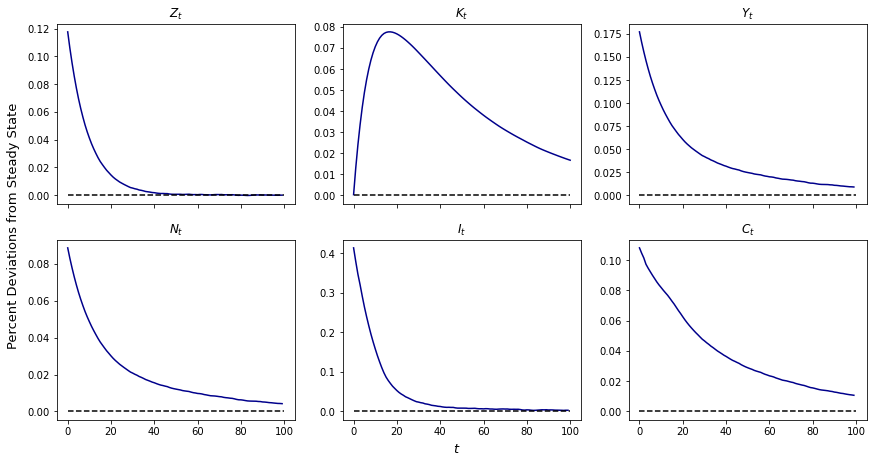

In [23]:
fig, ax = plt.subplots(2,3, sharex = True)
fig.subplots_adjust(right = 2, top = 1.5)

ax[0,0].plot(np.mean(zpath, axis = 1), color = 'darkblue')
ax[0,0].plot([0,100],[0,0], color = 'black', linestyle = '--')
ax[0,0].title.set_text('$Z_t$')

ax[0,1].plot(np.log(np.mean(output['kgrid'][kpath], axis = 1)) - np.log(Kss), color = 'darkblue')
ax[0,1].title.set_text('$K_t$')
ax[0,1].plot([0,100],[0,0], color = 'black', linestyle = '--')

ax[0,2].plot(np.log(np.mean(ypath, axis = 1)) - np.log(Yss), color = 'darkblue')
ax[0,2].title.set_text('$Y_t$')
ax[0,2].plot([0,100],[0,0], color = 'black', linestyle = '--')

ax[1,0].plot(np.log(np.mean(npath, axis = 1)) - np.log(Nss), color = 'darkblue')
ax[1,0].title.set_text('$N_t$')
ax[1,0].plot([0,100],[0,0], color = 'black', linestyle = '--')

ax[1,1].plot(np.log(np.mean(ipath, axis = 1)) - np.log(Iss), color = 'darkblue')
ax[1,1].title.set_text('$I_t$')
ax[1,1].plot([0,100],[0,0], color = 'black', linestyle = '--')

ax[1,2].plot(np.log(np.mean(cpath, axis = 1)) - np.log(Css), color = 'darkblue')
ax[1,2].title.set_text('$C_t$')
ax[1,2].plot([0,100],[0,0], color = 'black', linestyle = '--')

fig.text(1.05, 0.01, '$t$', ha='center', fontsize = 13)
fig.text(0.01, 0.8, 'Percent Deviations from Steady State', va='center', rotation='vertical', fontsize = 13)
plt.show()